# INFERNO HEP

## 1. Load CMS Open Data

In [1]:
import run_cmsopen
import importlib

In [9]:
importlib.reload(run_cmsopen)

<module 'run_cmsopen' from '/home/centos/dev/pytorch_inferno/experiments/run_cmsopen.py'>

In [2]:
#features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'MET_met', 'deltaPhiTauMet', 'mt', 'mTauJet']
features = ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
shape_syst = ["06_jes"] #, "taue"]
weight_syst = ["btag_weight1"]
norm_syst = ["jes_06", "taue", "btag_weight1"]
use_weights = False
mu, qcd, sig_norm = run_cmsopen.get_norm(norm_syst)

mu 348.45252731445095
QCD 2689.5053333309675
up 361.5752814461024
nominal 348.45252731445095
down 328.17359646673685
jes_06 16.70084248968277
up 355.0448159528871
nominal 348.45252731445095
down 331.4043246150459
taue 11.82024566892062
up 352.97329592678045
nominal 348.45252731445095
down 343.7486601906056
btag 4.612317868087416


In [10]:
# Parameters for INFERNO training
inferno_args = {}
# Signal and bkg
inferno_args["b_true"] = qcd
inferno_args["mu_true"] = mu
# Number of shape nuisances
inferno_args["n_shape_alphas"] = len(shape_syst) + len(weight_syst)
# Constraints on the nuisance parameters - typically should be N(0,1) if +-1sigma templates are provided
#inferno_args["shape_aux"] = [Normal(0,1) for i in range(len(shape_syst) + len(weight_syst))]
# Uncertainties on signal norm - should be Normal(0,s) with s in absolute event numbers
inferno_args["s_norm_aux"] = sig_norm #[Normal(0,10), Normal(0,10), Normal(0,10)]
# Boolean whether to let the background float
inferno_args["nonaux_b_norm"] = False

train_args = {}
train_args["lr"] = 1e-3
train_args["n_feats"] = len(features)
train_args["neurons"] = 100
train_args["bins"] = 10
train_args["temperature"] = 0.1
train_args["weights"] = False

OUTPATH = "/home/centos/data/inferno_cmsopen13"

bs = 1000
n_sig = 20000
epochs = 200

store = False

In [11]:
opendata, test_dl, samples, scaler = run_cmsopen.train(OUTPATH, features = features, 
                                                        shape_syst = shape_syst,
                                                        weight_syst = weight_syst,
                                                        norm_syst = norm_syst, 
                                                        epochs=epochs, bs=bs, n_sig=n_sig, 
                                                        inferno_args = inferno_args, 
                                                        train_args = train_args,
                                                        use_weights = use_weights,
                                                        store=store)

*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['06_jes']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************


/home/centos/dev/pytorch_inferno/experiments/run_cmsopen.py:170: FutureWarning: The default value of regex will change from True to False in a future version.
  samples["TTJets_signal_" + syst + ud].columns = samples["TTJets_signal_" + syst + ud].columns.str.replace(


## 2. Run HEP-like INFERNO model

In [5]:
import hep_model
from pytorch_inferno.inferno import *
from pytorch_inferno.callback import *
from pytorch_inferno.model_wrapper import *
from fastcore.all import partialler
from torch import optim, autograd, nn, Tensor

In [6]:
import importlib

In [15]:
importlib.reload(hep_model)

<module 'hep_model' from '/home/centos/dev/pytorch_inferno/experiments/hep_model.py'>

In [8]:
# Set up network
net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                nn.Linear(100,100), nn.ReLU(),
                nn.Linear(100,10), VariableSoftmax(0.1))

"""
net_inferno = nn.Sequential(nn.Linear(4,100),  nn.ReLU(),
                        nn.Linear(100,100), nn.ReLU(),
                        nn.Linear(100,1),  nn.Sigmoid())

"""
lt = LossTracker()
shape_norm_sigma = [0.05, 0.02]
s_norm_sigma = []#[0.05, 0.1]
hep_inf = hep_model.HEPInferno(b_true=qcd, mu_true=mu, n_shape_alphas=2, shape_norm_sigma=shape_norm_sigma,
                                 s_norm_sigma=s_norm_sigma, interp_algo="default")
#init_net(net_inferno)
model_inferno = ModelWrapper(net_inferno)

model_inferno.fit(100, data=opendata, opt=partialler(optim.Adam,lr=1e-3), loss=None,
                  cbs=[hep_inf,  lt])

inferno_trn_covs = hep_inf.covs["trn"]
inferno_val_covs = hep_inf.covs["val"]

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 2
shape idx [1, 2]
shape_norm_sigma [0.05, 0.02]
s_norm_sigma []
s_norm_idxs []
b_norm_sigma None
b_norm_idxs []
b_rate_param False
n_alpha 3
interp_algo default
use_hist False
ignore_loss False
*********************


1: Train=1203.3524462890625 Valid=894.1984692382813
2: Train=885.0862231445312 Valid=844.9078686523437
3: Train=844.4275341796875 Valid=821.8239111328126
4: Train=826.2816259765625 Valid=812.1788598632812
5: Train=808.9450073242188 Valid=800.50330078125
6: Train=803.6834106445312 Valid=794.1235424804687
7: Train=793.9062573242187 Valid=785.7852856445312
8: Train=787.7702392578125 Valid=788.384931640625
9: Train=780.2013989257813 Valid=776.9954223632812
10: Train=769.626376953125 Valid=771.6746826171875
11: Train=766.3981372070313 Valid=766.2499682617188
12: Train=759.8469482421875 Valid=768.960595703125
13: Train=757.5313305664063 Valid=758.9579150390625
14: Train=751.3687377929688 Valid=763.6223291015625
15: Train=748.5194653320312 Valid=762.5568798828125
16: Train=744.0734399414063 Valid=757.6024389648437
17: Train=744.1088061523437 Valid=762.734580078125
18: Train=741.9566015625 Valid=748.7569409179688
19: Train=737.9628515625 Valid=755.215908203125
20: Train=736.6620190429687 Valid

In [52]:
importlib.reload(hep_model)
df_inf, order_d = hep_model.pred_test(model_inferno, test_dl, name="inferno")

In [53]:
importlib.reload(plot)

<module 'plot' from '/home/centos/dev/pytorch_inferno/experiments/plot.py'>

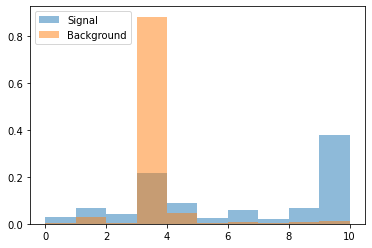

In [54]:
plot.plot_predictions(df_inf, plot_sorted=False, name="inferno")

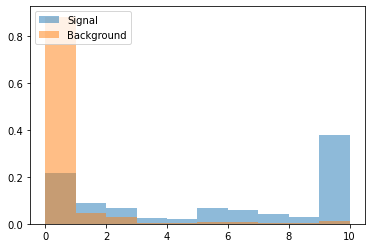

In [55]:
plot.plot_predictions(df_inf, plot_sorted=True, name="inferno")

## 3. Run BCE model

In [56]:
importlib.reload(hep_model)

<module 'hep_model' from '/home/centos/dev/pytorch_inferno/experiments/hep_model.py'>

In [57]:
net_bce = nn.Sequential(nn.Linear(4,12),  nn.ReLU(),
                        nn.Linear(12,8), nn.ReLU(),
                        nn.Linear(8,1),  nn.Sigmoid())
#init_net(net)    
ct = hep_model.HEPInferno(b_true=qcd, mu_true=mu, n_shape_alphas=2, shape_norm_sigma=shape_norm_sigma,
                                 s_norm_sigma=s_norm_sigma, interp_algo="default", ignore_loss=True,
                                 use_hist=True)
lt = LossTracker()
model_bce = ModelWrapper(net_bce)
model_bce.fit(100, data=opendata, opt=partialler(optim.Adam), loss=nn.BCELoss(),
              cbs=[lt, ct])
bce_trn_covs = ct.covs["trn"]
bce_val_covs = ct.covs["val"]

*********************
Summary INFERNO setup
b_true 2689.5053333309675
mu_true 348.45252731445095
nshape_alphas 2
shape idx [1, 2]
shape_norm_sigma [0.05, 0.02]
s_norm_sigma []
s_norm_idxs []
b_norm_sigma None
b_norm_idxs []
b_rate_param False
n_alpha 3
interp_algo default
use_hist True
ignore_loss True
*********************


1: Train=0.7857491207122803 Valid=0.7588868522644043
2: Train=0.7578328371047973 Valid=0.7306310248374939
3: Train=0.7191536045074463 Valid=0.6882984161376953
4: Train=0.6644084978103638 Valid=0.635298421382904
5: Train=0.602267656326294 Valid=0.580184543132782
6: Train=0.5411978578567505 Valid=0.5304959774017334
7: Train=0.4886709129810333 Valid=0.4900115025043488
8: Train=0.4479559659957886 Valid=0.45982710003852845
9: Train=0.4184409463405609 Valid=0.4375260210037231
10: Train=0.39684521555900576 Valid=0.4201645076274872
11: Train=0.38063455939292906 Valid=0.4072401928901672
12: Train=0.36753557562828065 Valid=0.3962411069869995
13: Train=0.3565133786201477 Valid=0.38701961278915403
14: Train=0.347015084028244 Valid=0.3785527491569519
15: Train=0.33877712845802305 Valid=0.36987805247306826
16: Train=0.33194414258003235 Valid=0.3651492810249329
17: Train=0.325534371137619 Valid=0.36585104107856753
18: Train=0.3204807209968567 Valid=0.3613353514671326
19: Train=0.31627702474594116 Val

In [58]:
df_bce, _ = hep_model.pred_test(model_bce, test_dl, name="bce")

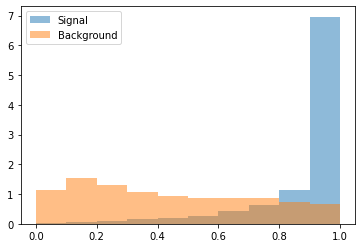

In [59]:
plot.plot_predictions(df_bce, plot_sorted=False, name="bce")

## 4. Plot results

In [20]:
import plot

In [76]:
importlib.reload(plot)

<module 'plot' from '/home/centos/dev/pytorch_inferno/experiments/plot.py'>

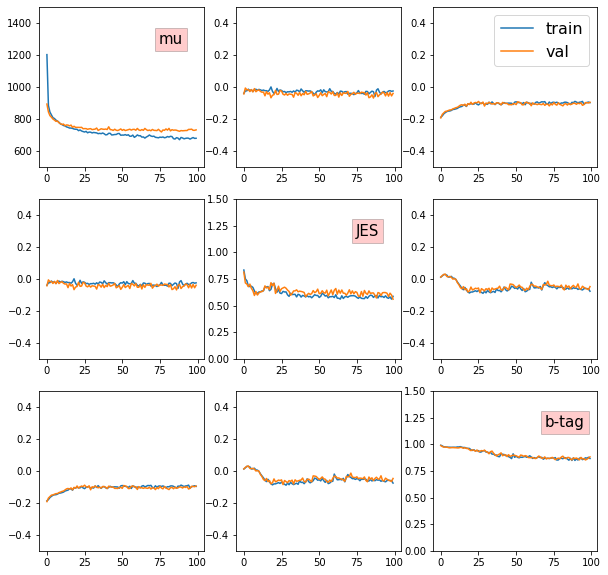

In [77]:
names = ["mu","JES",'b-tag']
plot.plot_cov_trnval(inferno_trn_covs, inferno_val_covs, names, stddev=False)

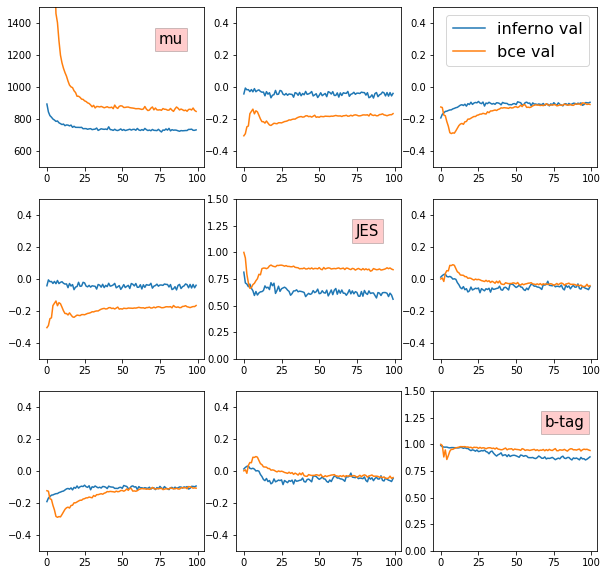

In [74]:
plot.plot_cov_infbce(bce_val_covs, inferno_val_covs, names)

## 5. Predict

In [89]:
importlib.reload(hep_model)

<module 'hep_model' from '/home/centos/dev/pytorch_inferno/experiments/hep_model.py'>

In [90]:
# Predict INFERNO
hep_model.pred_nominal(samples, features, model_inferno, scaler, name='inferno', order_d = order_d)
# Predict BCE
hep_model.pred_nominal(samples, features, model_bce, scaler, name="bce")   

## 6. Fit

In [188]:
import uproot3
import pyhf

In [195]:
import fit

In [413]:
importlib.reload(fit)

<module 'fit' from '/home/centos/dev/pytorch_inferno/experiments/fit.py'>

In [414]:
path = "/home/centos/data/inferno_cmsopen13"

In [415]:
fit.to_root(samples, systs = ["btag"], path=path)

### BCE

In [416]:
bins = np.linspace(0,1,10)
fit_var = "bce"
config = fit.create_config(path, fit_var, bins)

In [417]:
cabinetry.templates.build(config, method="uproot")

In [418]:
cabinetry.templates.postprocess(config)

In [419]:
workspace_path = path + "/workspace_bce.json"
ws = cabinetry.workspace.build(config)
cabinetry.workspace.save(ws, workspace_path)

In [420]:
spec = dict(pyhf.Workspace(ws).prune(modifier_types=["staterror"]))

In [421]:
spec

{'channels': [{'name': 'Signal_region',
   'samples': [{'name': 'Signal',
     'data': [0.9145426801405847,
      3.1277056862600148,
      4.442304796772078,
      7.042232731357217,
      10.123860788764432,
      13.272914531175047,
      20.245463417377323,
      37.06166619597934,
      252.2218365520239],
     'modifiers': [{'data': None, 'name': 'Signal_norm', 'type': 'normfactor'},
      {'name': 'JES',
       'type': 'normsys',
       'data': {'hi': 1.0376600915623995, 'lo': 0.9418028877873506}},
      {'name': 'JES',
       'type': 'histosys',
       'data': {'hi_data': [0.9059984035761126,
         3.3318009006688585,
         5.12797449415751,
         8.140153155352372,
         10.431602130968196,
         14.831692909343184,
         21.793652171863403,
         39.287283467433646,
         244.60236974648663],
        'lo_data': [0.8847016693948107,
         2.881477397450006,
         4.272265548460062,
         6.291732035734955,
         9.13381920732796,
         12

In [423]:
#model, data = cabinetry.model_utils.model_and_data(spec, asimov=True)
model, data = cabinetry.model_utils.model_and_data(spec)

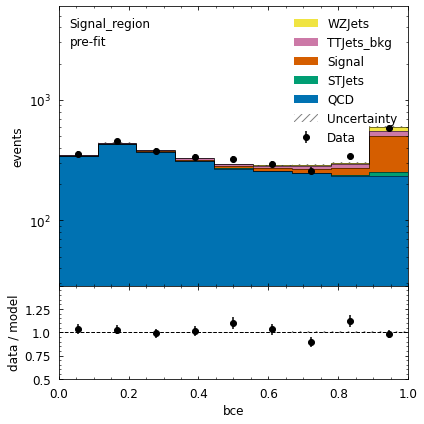

In [424]:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=config, log_scale=True)

In [425]:
fit_results = cabinetry.fit.fit(model, data)

In [426]:
fit_results

FitResults(bestfit=array([ 0.9449739 ,  0.09139672, -0.00163096,  1.02715487]), uncertainty=array([0.10143766, 1.02005488, 0.99344938, 0.02254115]), labels=['Signal_norm', 'JES', 'btag', 'QCD_norm'], corr_mat=array([[ 1.00000000e+00, -1.37706631e-01, -1.22158564e-01,
        -3.19930948e-01],
       [-1.37706631e-01,  1.00000000e+00, -9.16291265e-05,
        -1.64790713e-01],
       [-1.22158564e-01, -9.16291265e-05,  1.00000000e+00,
        -6.65192597e-04],
       [-3.19930948e-01, -1.64790713e-01, -6.65192597e-04,
         1.00000000e+00]]), best_twice_nll=83.14684216486275, goodness_of_fit=-1)

### INFERNO

In [ ]:
bins = np.linspace(0,9,9)
